# Sam Jackson, MAE 494, HW3

This code provides answers to the questions posed in Homework 3. The packages used in this homework assignment are numpy, matplotlib.pyplot, and pytorch. This homework also uses a modified version of the file gp.py, which was originally made by Thomas Huijskens, and uses the packages numpy, sklearn.gausian_process, scipy.stats, and scipy.optimize .

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t
from torch.autograd import Variable

## Problem 1
### 1.
First, formulating the problem as a least square problem to find $A_{12}$ and $A_{21}$. This is done by simply minimizing the sum of the squared difference between the measured pressures and the pressures calculated from the equilibrium equation for each value of $x_1$. Note:This a constrained problem due to the fact that $x_1$ and $x_2$ are related by being binary.

$$\begin{aligned} &\text{minimize:}_{A_{12},A_{21}} &&\sum^n_{i=1} [p_i - (x_{1i}exp(A_{12}(\frac{A_{21}x_{2i}}{A_{12}x_{1i}+A_{21}x_{2i}})^2)p^{sat}_{water}+x_{2i}exp(A_{21}(\frac{A_{12}x_{1i}}{A_{12}x_{1i}+A_{21}x_{2i}})^2)p^{sat}_{4,1dioxane})]^2 \\ &\text{subject to:} && x_1+x_2=1 \end{aligned}$$

Combining this to be a single unconstrained minimization problem that we can solve...

$$\begin{aligned} &\text{minimize:}_{A_{12},A_{21}} &&\sum^n_{i=1} [p_i - (x_{1i}exp(A_{12}(\frac{A_{21}(1-x_{1i})}{A_{12}x_{1i}+A_{21}(1-x_{1i})})^2)p^{sat}_{water}+(1-x_{1i})exp(A_{21}(\frac{A_{12}x_{1i}}{A_{12}x_{1i}+A_{21}(1-x_{1i})})^2)p^{sat}_{4,1dioxane})]^2 \end{aligned}$$

where $p^{sat}_{water}$ and $p^{sat}_{4,1dioxane}$ are constants that can be determined using given data and the Antoine equation.

To make the problem easier to be implemented in code, the summation function can instead be represented via matrix multiplication, for example if a is a nx1 matrix $a^2=a^Ta$ results in a 1x1 value which is the summation of $a_i^2$ for each value in $a$. Keeping in mind that $x_1$ and $p$ are nx1 matrices (in this case 11x1) as well as being the only matrices in the equation, we can modify the unconstrained problem the summation function into matrix multiplication as such...


$$ \begin {aligned} (p-(x_1exp(A_{12}(\frac{A_{21}(1-x_1)}{A_{12}x_1+A_{21}(1-x_1)})^2)p^{sat}_{water}+(1-x_1)exp(A_{21}(\frac{A_{12}x_1}{A_{12}x_1+A_{21}(1-x_1)})^2) p^{sat}_{4,1dioxane}))^T\end {aligned}$$

Though this form is less amenable to being written out it is equivalent to the form shown above, and more easily put into code. As such this form will be used when finding the solution shown below.

### 2.

Start with establishing the data given in the problem statement in code. This includes the measured data relating $x_1$ and $p$ and the data to acquire $p^{sat}_{water}$ and $p^{sat}_{1,4 dioxane}$ from the Antoine equation at $T=20^oC$

In [2]:
# Measurement data for x1 and p
x1 = Variable(t.tensor([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]), requires_grad=False)
pm = Variable(t.tensor([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5]), requires_grad=False)

# Saturation pressure data
T = 20 #degC
awater=[8.07131, 1730.63, 233.426]
a14dioxane=[7.43155, 1554.679, 240.337]

# Calculating saturation pressures for water and 1,4 dioxane

psatwater= Variable(t.tensor(10**(awater[0]-(awater[1]/(T+awater[2])))), requires_grad=False)
psat14dioxane=Variable(t.tensor(10**(a14dioxane[0]-(a14dioxane[1]/(T+a14dioxane[2])))), requires_grad=False)
print('Saturation pressure of T=20C water =', psatwater.item(), 'mmHg')
print('Saturation pressure of T=20C 1,4 dioxane =', psat14dioxane.item(), 'mmHg')

Saturation pressure of T=20C water = 17.473251342773438 mmHg
Saturation pressure of T=20C 1,4 dioxane = 28.824098587036133 mmHg


Before the minimize problem can be solved using either gradient descent or Newton's method, the gradient of the minimized function with respect to $A_{12}$ and $A_{21}$. This could be done by taking the derivative of the function, as we have done it in previous homeworks, or it could be done using the new method introduced in class by using PyTorch. I have chosen to solve the problem using a gradient descent method with the novel PyTorch way of finding the gradient, as shown below...

In [3]:
# Gradient descent with line search using PyTorch
eps = 1e-1 # Termination criteria
A = Variable(t.tensor([10.0, 5.0]), requires_grad=True) # Defining A's, A[0]=A_12, A[1]=A_21

# Defining loss function as the square sum of the equilibrium relation like defined in 1.
obj = lambda A, x1, psatwater, psat14dioxane:\
        t.dot((pm-(x1*psatwater*t.exp((A[0]*(A[1]*(1-x1))**2/((A[0]*x1+A[1]*(1-x1))**2)))\
        + (1-x1)*psat14dioxane*t.exp((A[1]*((A[0]*x1)**2)/((A[0]*x1+A[1]*(1-x1))**2))))),\
        (pm-(x1*psatwater*t.exp((A[0]*(A[1]*(1-x1))**2/((A[0]*x1+A[1]*(1-x1))**2)))\
        + (1-x1)*psat14dioxane*t.exp((A[1]*((A[0]*x1)**2)/((A[0]*x1+A[1]*(1-x1))**2))))))

# Armijo line search
def line_search(A,x1,psatwater,psatdioxane):
    a = 1.  # initialize step size
    phi = lambda a, A, x1, psatwater, psat14dioxane: obj(A,x1,psatwater,psat14dioxane) - a * 0.8 * A.grad @ A.grad.transpose(0,0)  # define phi as a search criterion
    while phi(a,A,x1,psatwater,psat14dioxane) < obj((A - a * A.grad),x1,psatwater,psat14dioxane):  # if f(x+a*d)>phi(a) then backtrack. d is the search direction
        a = 0.5 * a
    return a

error = 1 # Setting error initially higher than the cutoff


while error >= eps:  # Gradient descent process loops until the gradient is less than the termination criteria
    
    # Defining loss function as the square sum of the equilibrium relation like defined in 1.
    loss = obj(A,x1,psatwater,psat14dioxane)
    loss.backward() # Calculating gradient of loss function w.r.t. A
    error = A.grad.norm() # Setting error equal to the norm of the gradient
    # no_grad() specifies that the operations within this context are not part of the computational graph, i.e., we don't need the gradient descent algorithm itself to be differentiable with respect to A
    with t.no_grad():
        a = line_search(A,x1,psatwater,psat14dioxane) # Perform line search to ensure step size isn't too large
        A -= a*A.grad # Descending the gradient
        
        # need to clear the gradient at every step, or otherwise it will accumulate...
        A.grad.zero_()
        
# Printing out results of gradient descent
print('Optimized Value of A_12 =',A[0].data.numpy())
print('Optimized Value of A_21 =',A[1].data.numpy())
print('Final Value of loss function =',loss.data.numpy())

Optimized Value of A_12 = 1.9578605
Optimized Value of A_21 = 1.6896445
Final Value of loss function = 0.67023647


### 3.
To compare our solution with the data, let's calculate what the model predicts the values of $p$ will be for each value of $x_1$, then subtract the predicted values from the measured values.

In [4]:
# First calculating the predicted values of p for each x1
#for i in range(10):
#    predictionp = (x1[i]*psatwater*t.exp((A[0]*(A[1]**2)*(1-x1[i])*(1-x1[i]))/((A[0]*x1[i]+A[1]*(1-x1[i]))*(A[0]*x1[i]+A[1]*(1-x1[i]))))\
#        + (1-x1[i])*psat14dioxane*t.exp((A[1]*(A[0]**2)*(x1[i]*x1[i]))/((A[0]*x1[i]+A[1]*(1-x1[i]))*(A[0]*x1[i]+A[1]*(1-x1[i])))))
predictionp = (x1*psatwater*t.exp((A[0]*(A[1]*(1-x1))**2/((A[0]*x1+A[1]*(1-x1))**2)))\
        + (1-x1)*psat14dioxane*t.exp((A[1]*((A[0]*x1)**2)/((A[0]*x1+A[1]*(1-x1))**2))))
print('Measured values of p =',pm.data.numpy())
print('Predicted values of p =',predictionp.data.numpy())

#Then subtracting the predicted values of p from the measured values of p to see the difference.
print('Difference in predicted and measured values of p =', (pm-predictionp).data.numpy())

Measured values of p = [28.1 34.4 36.7 36.9 36.8 36.7 36.5 35.4 32.9 27.7 17.5]
Predicted values of p = [28.824099 34.641922 36.451233 36.866104 36.87291  36.748795 36.389854
 35.38533  32.949886 27.733051 17.473251]
Difference in predicted and measured values of p = [-0.7240982  -0.24192047  0.24876785  0.0338974  -0.07291031 -0.04879379
  0.11014557  0.01467133 -0.0498848  -0.03305054  0.02674866]


As we can see, there is a little difference from the predicted and measured values. This could have been guessed from looking at the final value of the loss function in section 2., as it had a fairly small value of ~0.67 while the magnitude of the gradient had reduced to a near zero value, indicating that this was the local minimum. This slight discrepancy in the predicted and measured values likely comes from either error in the used measurements of p or the a values to calculate $p^{sat}_{water}$ and $p^{sat}_{1,4 dioxane}$, or from the fact that a relatively high termination criteria was chosen of $eps=1e^{-1}$. Regardless, the values of $A_{12}$ and $A_{21}$ found above are very close to the best values to fit the measured data, and they fit the data quite well.

## Problem 2

The goal of this problem is to minimize the following function with respect to $x_1$ and $x_2$ using Bayesian optimization...

$$(4-2.1x_1^2+\frac{x_1^4}{3})x_1^2+x_1*x_2+(-4+4x_2^2)x_2^2$$


To minimize this function using Bayesian optimization I followed the tutorial article linked in the Homework 3 by Thomas  Huijskens. After reading over the theory behind the method, I followed the link in the article to the python implementation of this theory using sklearn.gaussian_process on Thomas's github. Of the three files there, gp.py is the file that creates three functions that build up to an easy to use Bayesian optimization function. To use this in my own work, I have copied over gp.py into a references folder in the highest level of this GitHub repository and will be calling it to enable the use of these functions...

In [8]:
# Enabling the use of bayesian_optimisation from gp.py in the tutorial
%run ./../../References/gp.py

Now, the function that performs the bayesian optimization can be used in this notebook. However, it should be noted that I have modified the original file from the tutorial. On line 164 of the file, I have changed the parameter greater_is_better from the default =True vale to =False to switch the non-random bayesian optimization from seeking to maximize the function to seeking to minimize it. With this change the only thing left to be done is define the function to be minimized in code, run the function, and analyze the results, as done below.

Optimized value of x1= -0.1516759612771137
Optimized value of x2= 0.720146355495625
Corresponding value of loss function for optimized x1, x2 = -1.016928440406183


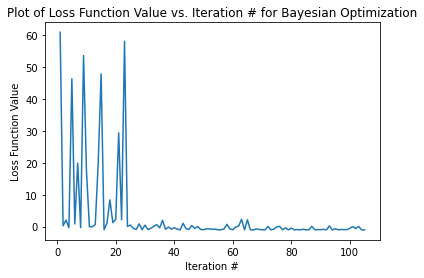

In [14]:
# Choosing the number of iterations to run (I arbitrarily chose 100)
n_iters = 100

# Choosing the number of pre-samples to the loss function (I arbitrarily chose 5)
n_pre_samples = 5

# Defining the function to be minimized
sample_loss = lambda x: (4-2.1*(x[0]**2)+(x[0]**4)/3)*x[0]**2+x[0]*x[1]+(-4+4*x[1]**2)*x[1]**2

# Defining the parameter bounds for x1 and x2
bounds = np.array([[-3,3],[-2,2]])

# Running the bayesian optimisation function with the predefined parameters, making sure to not use pure random search
xbaye, lossbaye = bayesian_optimisation(n_iters, sample_loss, bounds, x0 = None, n_pre_samples = 5,gp_params = None, random_search = None, alpha=1e-5, epsilon=1e-7)

# Creating a plot showing the progression of the optimization function as it optimized x1 and x2
plt.plot(np.linspace(1,(n_iters+n_pre_samples),(n_iters+n_pre_samples)), lossbaye)
plt.title('Plot of Loss Function Value vs. Iteration # for Bayesian Optimization')
plt.xlabel('Iteration #')
plt.ylabel('Loss Function Value')

# Printing the optimized value of x1 and x2 alongside the corresponding value for the loss function 
print('Optimized value of x1=', xbaye[-1,0])
print('Optimized value of x2=', xbaye[-1,1])
print('Corresponding value of loss function for optimized x1, x2 =', lossbaye[-1])


As we can see, the bayesian optimization method returned a set of $x_1$ and $x_2$ which produce a loss function value which is just under 0, which is much lower than most other possible solutions to the given function. But, as shown by the graph, the function took many iteriations to determine the area in which contains the optimized answer due to the fact that the function uses the idea of expected improvement. The behavior where the function spikes up to higher loss values in the first tens of iterations is a result of the function exploring areas of the bounds where there is a high uncertainty, and thus a high expected improvement, and finding that this portion of the bounds is not optimized. However as we can see, the function quickly explores the whole of the space and starts honing in on the portion of the space in which is more explored, but yields lower values of the loss function. 

Overall, even though the method does utilize essentially random search towards the start of its process, one can easily see that the process is significantly more effective than random search at consistantly finding values which minimize a given function.